# Import needed modules

In [1]:
# import system libs 
import os
import time
import shutil
import itertools

# import data handling tools 
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# Create needed functions

#### Function to Create Data Frame from Dataset

In [2]:
# Generate data paths with lables 
def define_paths(dir):
    filepaths = []
    labels = []

    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    #print(filepaths,labels)

    return filepaths, labels


# Conctainate data pathes with lables into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)


# Split data into train, validation, and test
def split_data(tr_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)
    
    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)
    
    return train_df, valid_df, test_df 

#### Function to generate images from dataframe

In [3]:
def create_model_data (train_df, valid_df, test_df, batch_size):
    
    ''' This function takes train, validation, and test dataframe and fit them into image data generator, because model takes 
         data from image data generator. 
         Image data generator converts images into tensors. '''
    

    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)
    
    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    
    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img
    
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)
    
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)
    
    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size) 
    
    
    return train_gen, valid_gen, test_gen


In [4]:
# print(train_gen[0].shape)

#### Function to display data sample

In [5]:
def show_images(gen):
    
    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index} 
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string 
    images, labels = next(gen)        # get a batch size samples from the generator
    
    # calculate number of dispalyed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images
    
    plt.figure(figsize= (20, 20))
    
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

#### **Callbacks** 
<br> 
Callbacks : Helpful functions to help optimize model training  <br> 
Examples: stop model training after specfic time, stop training if no improve in accuracy and so on.

In [6]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, base_model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.base_model = base_model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):       
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights) 


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100 
        loss = logs.get('loss')
        
        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '') 


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss
            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                else:
                    self.count = self.count + 1 # increment the patience counter
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

#         else:
#             if self.ask_epoch != None and self.ask_permission != 0:
#                 if epoch + 1 >= self.ask_epoch:
#                     msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
#                     print(msg)
#                     ans = input('')
#                     if ans == 'H' or ans == 'h':
#                         msg = f'training has been halted at epoch {epoch + 1} due to user input'
#                         print(msg)
#                         self.model.stop_training = True # stop training
#                     else:
#                         try:
#                             ans = int(ans)
#                             self.ask_epoch += ans
#                             msg = f' training will continue until epoch ' + str(self.ask_epoch)
#                             print(msg)
#                             msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
#                             print(msg)
#                         except:
#                             print('Invalid')

#### Function to plot history of training

In [7]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()


#### Function to create Confusion Matrix

In [8]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)
	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')
	else:
		print('Confusion Matrix, Without Normalization')
	print(cm)
	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

In [9]:
!pip install git+https://github.com/cleanlab/cleanvision.git
from cleanvision.imagelab import Imagelab

def analyze_dataset(sdir):    
    slength=len(sdir)
    imagelab = Imagelab(sdir)
    imagelab.find_issues()
    #imagelab.report()
    print(imagelab.issue_summary)
    delete_list=[]
    
    exact_duplicates=list(imagelab.info['exact_duplicates']['sets'])
    length=len(exact_duplicates)
    if length == 0:
        print('No duplicate images were found')
    else:
        for i, ed in enumerate(exact_duplicates):
            lengthp=len(ed) 
            for j in range(1, lengthp):
                if ed[j] not in delete_list:
                    delete_list.append(ed[j])

    near_duplicates=list(imagelab.info['near_duplicates']['sets'])
    length=len(near_duplicates)
    if length == 0:
        print('No near duplicate images were found')
    else:
        dup_count=0
        for i, ed in enumerate(near_duplicates):
            lengthp=len(ed) 
            for j in range(1, lengthp):
                if ed[j] not in delete_list:
                    delete_list.append(ed[j])
    to_light = imagelab.issues[imagelab.issues["is_light_issue"] == True].sort_values(by=['light_score']).index.tolist()
    length=len(to_light)
    if length == 0:
        print('There are no images that are to light')
    else:
        ans=input('Enter P to print all ', length, ' to light images or press enter to not print ')
        if ans == 'P' or ans == 'p':
            for f in to_light:
                print (f)
        ans=int(input(' enter an integer for how many to light images to plot, enter 0 for no plot'))
        if ans != 0:
            show_images(to_light, ans, sdir)        
        ans=input('Enter D to delete the ', length, ' to light images, to not delete press Enter ' )
        if ans == 'D' or ans == 'd':
            for imgpath in to_light:
                if imgpath not in delete_list:
                    delete_list.append(imgpath)
    return delete_list

  Cloning https://github.com/cleanlab/cleanvision.git to /tmp/pip-req-build-oxnvmdfc
  Running command git clone --filter=blob:none --quiet https://github.com/cleanlab/cleanvision.git /tmp/pip-req-build-oxnvmdfc
  Resolved https://github.com/cleanlab/cleanvision.git to commit 6a549fee1e82094a36a5bf2fdf58690349af7c5c
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 17.7 MB/s eta 0:00:00
  Created wheel for cleanvision: filename=cleanvision-0.3.1-py3-none-any.whl size=54193 sha256=ec59b6c63fcaab5764a95c61f2a65f32a4cf7203efb07ca7e682cc2497ab251d
  Stored in directory: /tmp/pip-ephem-wheel-cache-nc5bh8wd/wheels/ff/3c/60/775273f19fb1978a17aeff108b7c80a2417d5e126eb3b0d7f5
Successfully built cleanvision
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.1.1
    Uninstalling Pillow-9.1.1:
      Successfu

In [10]:
analyze_dataset('/kaggle/input/philippines-rice-diseases/resized_raw_images/resized_raw_images')

Reading images from /kaggle/input/philippines-rice-diseases/resized_raw_images/resized_raw_images
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/1380 [00:00<?, ?it/s]

  0%|          | 0/1380 [00:00<?, ?it/s]

Issue checks completed. 22 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
         issue_type  num_images
0   low_information          19
1   near_duplicates           2
2            blurry           1
3              dark           0
4         grayscale           0
5             light           0
6  odd_aspect_ratio           0
7          odd_size           0
8  exact_duplicates           0
No duplicate images were found
There are no images that are to light


['/kaggle/input/philippines-rice-diseases/resized_raw_images/resized_raw_images/sheath_blight/Sheath_blight (62).jpg']

# Model Structure

#### Start Reading Dataset

Found 1104 validated image filenames belonging to 14 classes.
Found 138 validated image filenames belonging to 14 classes.
Found 138 validated image filenames belonging to 14 classes.


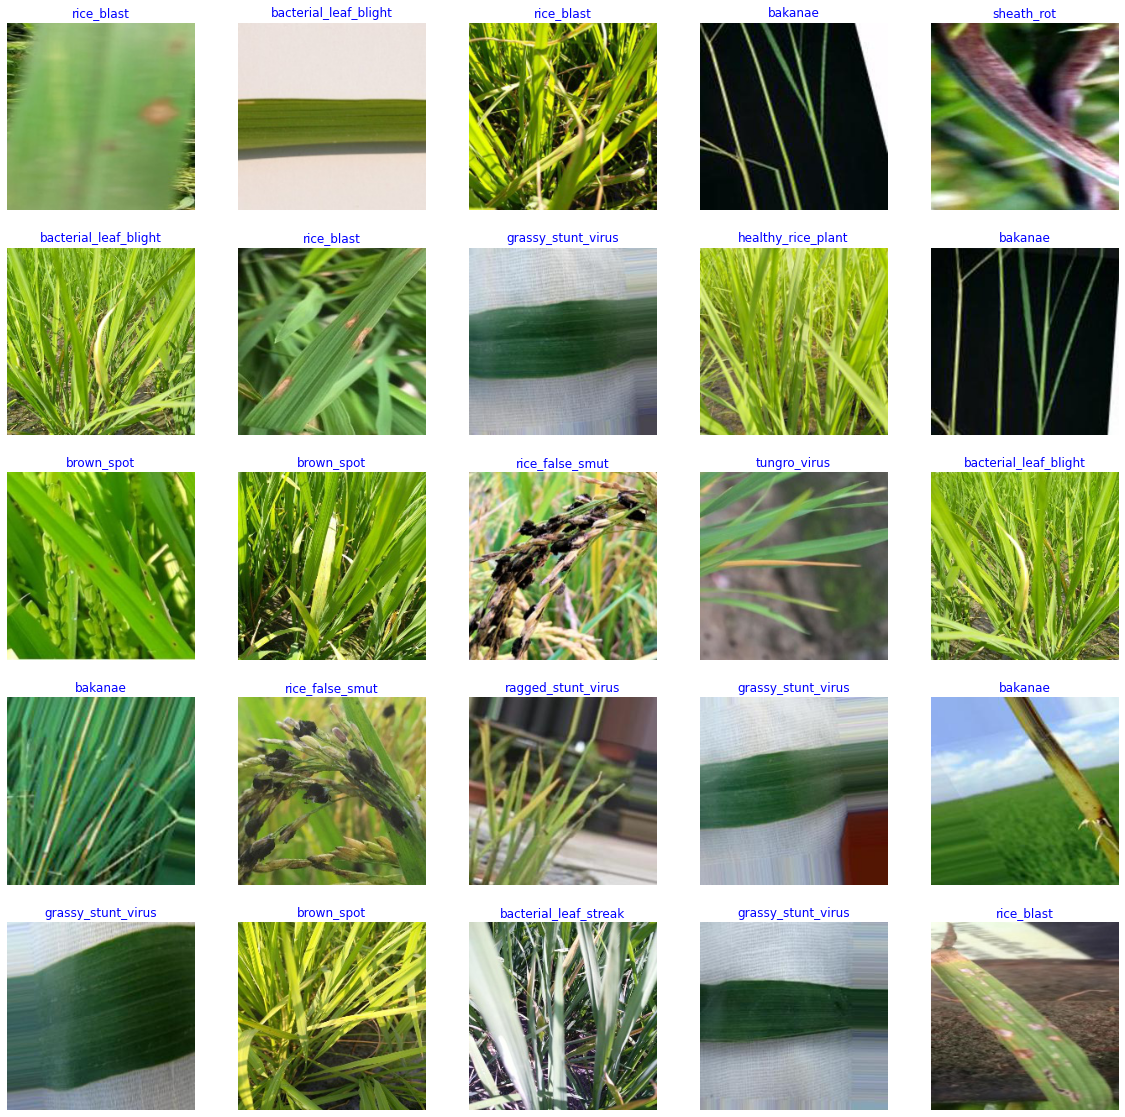

In [11]:
# Get Dataframes
#data_dir = '/kaggle/input/paddy-disease-classification/train_images'
data_dir = '/kaggle/input/philippines-rice-diseases/resized_raw_images/resized_raw_images'
train_df, valid_df, test_df = split_data(data_dir)

# Get Generators
batch_size = 40
train_gen, valid_gen, test_gen = create_model_data(train_df, valid_df, test_df, batch_size)

# Display Image Samples
show_images(train_gen)

#### Generic Model Creation

In [12]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
#base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
#base_model=tf.keras.applications.MobileNetV3Small(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
#base_model=tf.keras.applications.MobileNetV3Large(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
#base_model=tf.keras.applications.EfficientNetV2B0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
#base_model=tf.keras.applications.EfficientNetV2B1(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
#base_model=tf.keras.applications.EfficientNetV2B2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
#base_model=tf.keras.applications.InceptionResNetV2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max',classifier_activation=None )
base_model=tf.keras.applications.ResNet50(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                3598      
Total params: 24,124,046
Trainable params: 24,066,830
Non-trainable params: 57,216
_________________________________________________________________


#### Set Callback Parameters

In [13]:
batch_size = 40     # set batch size for training
epochs = 100         # number of all epochs in training
patience = 1 		    # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3 	# number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9 	  # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor = 0.5 		    # factor to reduce lr by
ask_epoch = 5		    # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, base_model= base_model, patience= patience,
            stop_patience= stop_patience, threshold= threshold, factor= factor,
            batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

#### Train model

In [14]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0,  callbacks= callbacks, validation_data= valid_gen, validation_steps= None, shuffle= False)

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /100    9.341   58.062  17.14308  23.913   0.00100  0.00100  accuracy     0.00    22.51  
 2 /100    7.884   80.163  12.98539  34.058   0.00100  0.00100  accuracy    38.07     6.85  
 3 /100    7.021   90.036   8.23543  65.217   0.00100  0.00100  val_loss    36.58     6.84  
 4 /100    6.359   94.565   7.65403  70.290   0.00100  0.00100  val_loss     7.06     6.75  
 5 /100    5.818   97.373   5.98395  86.232   0.00100  0.00100  val_loss    21.82     6.81  
 6 /100    5.325   98.188   5.38190  90.580   0.00100  0.00100  val_loss    10.06     6.84  
 7 /100    4.916   98.913   5.04711  89.130   0.00100  0.00100  val_loss     6.22     6.82  
 8 /100    4.547   98.822   4.57440  91.304   0.00100  0.00100  val_loss     9.37     6.78  
 9 /100    4.196   99.819   4.23833  92.754   0.00100  0.00100  val_loss     7.35     6.92  
10 /100    3.880   99.638   3.90922  92.029   0.00100  0.00100  val_los

#### Display model performance

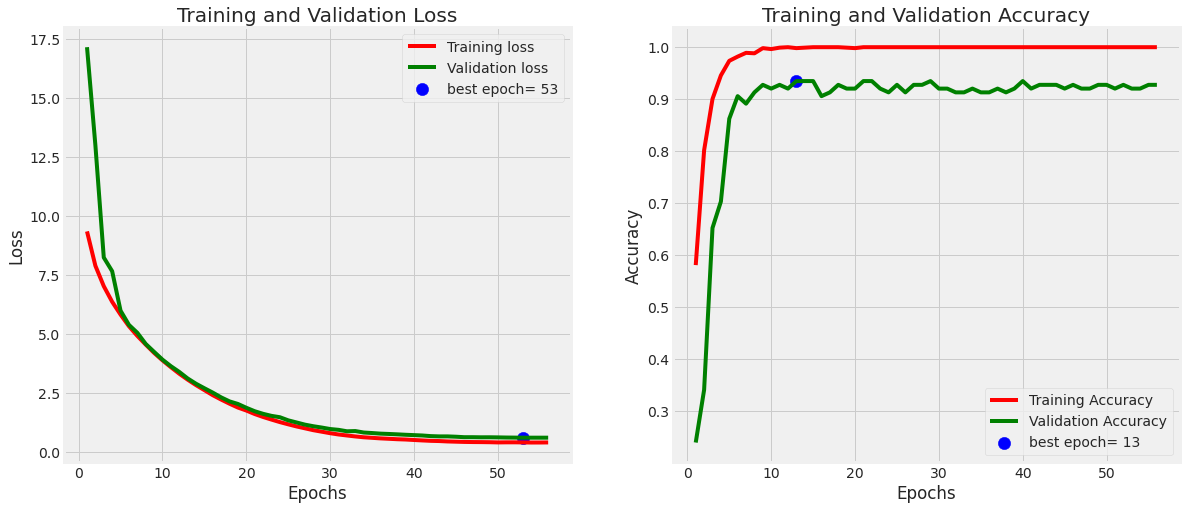

In [15]:
plot_training(history)

### Evaluate model

In [16]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

2/2 [==============================] - 1s 127ms/step - loss: 0.4700 - accuracy: 0.9855
Train Loss:  0.373302698135376
Train Accuracy:  1.0
--------------------
Validation Loss:  0.5785906910896301
Validation Accuracy:  0.925000011920929
--------------------
Test Loss:  0.47000420093536377
Test Accuracy:  0.9855072498321533


### Get Predictions

In [17]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[13  9  3 13 12  3  7  0  4  4 10  5 10 12  8  9  8  2  0  9 12  6  5  4
 12  1  1  3  1  0  6  1  5  6  6  8  7 11 11 13  4  8  2 13 13  3 13  9
  0  3 11 10 10  5 11  5  1  1  3  2 13  0  0  1  6  7  9  7 11  7  5 10
  7  8 10  5  8  6  8  1 12  8  9  7  2 12  3  1 12  4 11  4  2  5  7  2
  1  1  8  9  6  5 10  6 10  0 13  4 11 10  4  9  3 12  0  7  4  2  3 10
 11 12  9 12  5  2  4  0 13  2  6  2 13  0 11  7  3  9]


#### Confusion Matrics and Classification Report

Confusion Matrix, Without Normalization
[[10  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  9  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  9  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  9  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 10]]
                       precision    recall  f1-score   support

bacterial_leaf_blight       1.00      1.00      1.00        10
bacterial_leaf_streak       0.91      1.00      0.95        10
              bakanae       1.00      1.00      1.00        10
           brown_spot       0.90      0.90      0.90        10
   grassy_stu

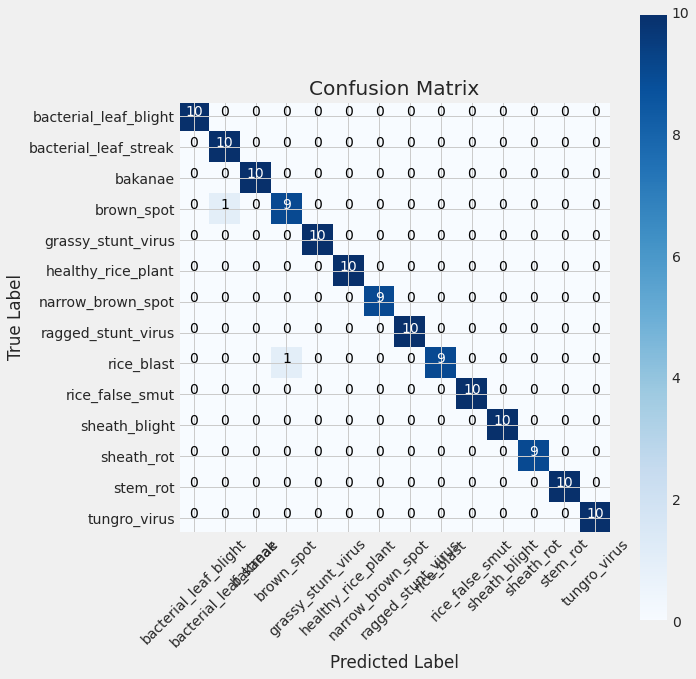

In [18]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

In [19]:
model.save("image_classification.h5",include_optimizer=True)

In [20]:
saved_model=tf.keras.models.load_model('/kaggle/working/image_classification.h5')

In [21]:
saved_predictions = saved_model.predict_generator(test_gen)
saved_y_pred = np.argmax(saved_predictions, axis=1)
print(saved_y_pred)

[13  9  3 13 12  3  7  0  4  4 10  5 10 12  8  9  8  2  0  9 12  6  5  4
 12  1  1  3  1  0  6  1  5  6  6  8  7 11 11 13  4  8  2 13 13  3 13  9
  0  3 11 10 10  5 11  5  1  1  3  2 13  0  0  1  6  7  9  7 11  7  5 10
  7  8 10  5  8  6  8  1 12  8  9  7  2 12  3  1 12  4 11  4  2  5  7  2
  1  1  8  9  6  5 10  6 10  0 13  4 11 10  4  9  3 12  0  7  4  2  3 10
 11 12  9 12  5  2  4  0 13  2  6  2 13  0 11  7  3  9]


In [22]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')

In [23]:
new_model = tf.keras.models.load_model('/kaggle/working/saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                3598      
Total params: 24,124,046
Trainable params: 24,066,830
Non-trainable params: 57,216
_________________________________________________________________


In [24]:
!zip -r model.zip '/kaggle/working/saved_model'

  adding: kaggle/working/saved_model/ (stored 0%)
  adding: kaggle/working/saved_model/my_model/ (stored 0%)
  adding: kaggle/working/saved_model/my_model/saved_model.pb (deflated 92%)
  adding: kaggle/working/saved_model/my_model/assets/ (stored 0%)
  adding: kaggle/working/saved_model/my_model/variables/ (stored 0%)
  adding: kaggle/working/saved_model/my_model/variables/variables.index (deflated 80%)
  adding: kaggle/working/saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: kaggle/working/saved_model/my_model/keras_metadata.pb (deflated 96%)
